# EDA Project 2 - 
_______

### Data Description
These data provide a window into how people are interacting with the government online. The data come from a unified Google Analytics account for U.S. federal government agencies known as the Digital Analytics Program. This program helps government agencies understand how people find, access, and use government services online. The program does not track individuals, and anonymizes the IP addresses of visitors.

Not every government website is represented in these data. Currently, the Digital Analytics Program collects web traffic from around 400 executive branch government domains, across about 5,700 total websites, including every cabinet department. We continue to pursue and add more sites frequently; to add your site, email the Digital Analytics Program.

## Question and Problem Definition

## Workflow Goals

### Import Libraries

In [2]:
from collections.abc import Sequence
import datetime
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

import pyarrow.parquet as pq
from tqdm import tqdm

%matplotlib inline

### Data Acquisition
**Background**

One of the challenges of this project was acquiring data.  The original dataset we prospected was found to be corrupted. 
After looking at the data, we found that the there were so many errors, it would have been nearly impossible to complete the project as planned.

**Error Source** 

The data was corrupted by human error.  The developers who maintain the dataset, allowed synthetic data to contaminate the downloadable `.csv` files they make available to the public.  Over half of the observations contained website domains such as www.fakesite.com.  

**Solution**

Instead of waiting for the data errors to be fixed and run the risk of having incomplete data for our project, we decided to proceed with acquiring data through the API.  We did need to adjust our initial data questions as the API is still in BETA and did not have the same headers available as the `.csv` files.  Where we did lose some variable information, we did gain the ability to acquire time-series data, which was not available in the original dataset.  

The analytics.usa.gov has made the following datasets available for download:
- Download: Refers to the number of times a file or asset has been downloaded from a website.
- Traffic-source: Refers to the channel or medium that a visitor used to reach a website, such as organic search, social media, or paid advertising.
- Device-model: Refers to the specific model of device that a visitor used to access a website, such as an iPhone X or Samsung Galaxy S21.
- Domain: Refers to the main domain name of a website, such as example.com.
- Site: Refers to a specific subdomain or section of a website, such as blog.example.com.
- Second-level-domain: Refers to the part of a domain name that comes before the top-level domain (TLD), such as example in example.com.
- Language: Refers to the primary language of a website or the language preference of a visitor's browser.
- OS-browser: Refers to the combination of operating system and web browser used by a visitor to access a website, such as Windows 10 and Chrome.
- Windows-browser: Refers specifically to web browsers running on the Windows operating system, such as Internet Explorer or Microsoft Edge.
- Browser: Refers to the specific web browser used by a visitor to access a website, such as Chrome, Firefox, or Safari.
- Windows-ie: Refers specifically to the Internet Explorer web browser running on the Windows operating system.
- OS: Refers to the specific operating system used by a visitor to access a website, such as Windows, macOS, iOS, or Android.
- Windows: Refers specifically to the Windows operating system.
- IE: Refers specifically to the Internet Explorer web browser.

#### Reports we are analyzing	

Domain_report_all_agencies.parquet
Contains daily visits per domain for all participating agencies
Example
Download_report_all_agencies.parquet
Daily # of file downloads (include page and file title) from agencies sites
Example
Language_report_all_agencies.parquet
Daily visits per language to each agency sites
Example
Second-level-domain_report_all_agencies.parquet
Is not clear what is the difference between this and the domain report
Should we drop it? 
Example
Site_report_all_agencies.parquet
Is not clear what is the difference between this and the domain report
Should we drop it?
Example
Traffic-source_report_all_agencies.parquet
Daily visits to agencies sites broken down by source domain
Example



#### Agencies in scope
‘health-human-services', 
'postal-service', 
'social-security-administration',
'treasury'

### Load Dataset
(observations & notes)

In [3]:
df_sites = pd.read_parquet('../DATA_Project2/site_report_all_agencies.parquet')
df_sites.head()


,id,date,report_name,report_agency,domain,visits
0,62048352,2020-03-31,site,health-human-services,cdc.gov,12248683
1,62048353,2020-03-31,site,health-human-services,ncbi.nlm.nih.gov,6300062
2,62048354,2020-03-31,site,health-human-services,medlineplus.gov,2033758
3,62048355,2020-03-31,site,health-human-services,pubmed.ncbi.nlm.nih.gov,1287141
4,62048356,2020-03-31,site,health-human-services,fda.gov,785867


In [4]:
df_language = pd.read_parquet('../DATA_Project2/language_report_all_agencies.parquet')
df_language.head()

,id,date,report_name,report_agency,visits,language
0,62039536,2020-03-31,language,health-human-services,19436137,en-us
1,62039537,2020-03-31,language,health-human-services,1526721,en-gb
2,62039538,2020-03-31,language,health-human-services,966842,es-es
3,62039539,2020-03-31,language,health-human-services,614554,es-419
4,62039540,2020-03-31,language,health-human-services,539171,zh-cn


In [5]:
df_traffic_source = pd.read_parquet('../DATA_Project2/traffic-source_report_all_agencies.parquet')
df_traffic_source.head()

,id,date,report_name,report_agency,source,visits,has_social_referral
0,62042829,2020-03-31,traffic-source,health-human-services,google,17009249,No
1,62042830,2020-03-31,traffic-source,health-human-services,(direct),4042668,No
2,62042831,2020-03-31,traffic-source,health-human-services,bing,615788,No
3,62042832,2020-03-31,traffic-source,health-human-services,youtube.com,645586,Yes
4,62042833,2020-03-31,traffic-source,health-human-services,cdc.gov,463127,No


### IV. Data Exploration
Viewing and describing the data

**Question 1.** How many sites and agencies does the site report contain information about?

In [6]:
df_sites.groupby(['report_agency'])['domain'].nunique().sort_values(ascending=False)

report_agency
health-human-services             1058
treasury                           120
postal-service                      57
social-security-administration       9
Name: domain, dtype: int64

- **Question 1 answer:** 
    - The site reports contains information about 4 agencies (Health & Human Services, Treasury, Postal Service and Social Secutiry Administration)
    - Health & Human Services is the agency with the largest number of domains (1058), whereas Social Security Administration is the lower (9)
    - Below is a spot-check of the 9 domains under Social Security Administration

In [7]:
df_sites[df_sites['report_agency'] == 'social-security-administration']['domain'].unique()

array(['ssa.gov', 'faq.ssa.gov', 'search.ssa.gov', 'secure.ssa.gov',
       'choosework.ssa.gov', 'oig.ssa.gov', 'beta.ssa.gov',
       'yourtickettowork.ssa.gov', 'oig-demo.ssa.gov'], dtype=object)

**Question 5.** Do we understand the meaning of all columns?

In [8]:
df_sites.columns

Index(['id', 'date', 'report_name', 'report_agency', 'domain', 'visits'], dtype='object')

In [9]:
df_language.columns

Index(['id', 'date', 'report_name', 'report_agency', 'visits', 'language'], dtype='object')

In [10]:
df_traffic_source.columns

Index(['id', 'date', 'report_name', 'report_agency', 'source', 'visits',
       'has_social_referral'],
      dtype='object')

- **Question 5 answer:** While there is some good information about the data at https://analytics.usa.gov/data/ and https://digital.gov/guides/dap/, there doesn't seem to be detailed documentation for each of the reports we pulled. This might be in part due to the fact that the API we used is in beta mode. However, the column names are mostly self-explanatory and through spot checking the data and with some experience having worked with Web traffic datasets in the past, we were able to come to the following conclusions:
    - `id`: random unique identifier for each row in each report. It can't be used to join across reports so it could potentially be dropped.
    - `date`: datetime field
    - `report_name`: name of each of the 3 reports pulled
    - `report_agency`: name of each of the 4 agencies for which we have data
    - `domain`: web domain. Each domain (eg. ssa.gov) aggregates data for all its sites (eg. ssa.gov/retirement)
    - `visits`: number of visits to each individual domain. Tipically the page_view metric counts the number of times a page is viewed, whereas visits counts the number of sessions for visitors
    - `language`: we think this represents the inferred language of the user visiting the page
    - `source`: the page where the visit originated from. For example, if someone reaches ssa.gov by clicking a link at google.com, then google.com would be the source for that visit
  

### IV. Visualizing and Analyzing Results

**Question 1.** What domains were the most visited (top 5) for the Postal Service and Treasury agencies during Q2'2020 (chose this period to investigate any potential impact from the COVID-19 pandemic in visits) and compared to Q1'2020. Any interesting observations?

In [36]:
df_sites_filtered = df_sites[(df_sites['report_agency'] == 'postal-service') | (df_sites['report_agency'] == 'treasury')]
df_q1q2 = df_sites_filtered[df_sites_filtered['date'].between('2020-01-01', '2020-06-30')]
df_top_domains = df_q1q2.groupby(['report_agency', 'domain', df_q1q2['date'].dt.quarter])['visits'].sum().reset_index()
top_domains = df_top_domains.pivot_table(index=['report_agency', 'domain'], columns='date', values='visits', fill_value=0).reset_index()
top_domains.columns = ['report_agency', 'domain', 'q1_visits', 'q2_visits']
top_domains['q2_visits_qoq_percent']=(top_domains['q2_visits'] / top_domains['q1_visits']-1)*100
top_domains = top_domains.sort_values(['report_agency', 'q2_visits'], ascending=[True, False])
for agency in top_domains['report_agency'].unique():
    print(f"Top 5 domains for {agency}:")
    print(top_domains[top_domains['report_agency'] == agency][['domain', 'q1_visits', 'q2_visits','q2_visits_qoq_percent']].head(5).to_string(index=False))
    print()

Top 5 domains for postal-service:
                   domain  q1_visits  q2_visits  q2_visits_qoq_percent
           tools.usps.com  980082084 2893891548             195.270324
             reg.usps.com  226644279  632966368             179.277452
                 usps.com  204138918  499869436             144.867290
informeddelivery.usps.com  130993182  411768024             214.343096
               m.usps.com   61172878  154207677             152.085045

Top 5 domains for treasury:
           domain  q1_visits  q2_visits  q2_visits_qoq_percent
          irs.gov  659080272 2767759202             319.942656
  sa.www4.irs.gov  469207200 1583563783             237.497759
home.treasury.gov   14265373   54868030             284.623872
     apps.irs.gov   31928556   41738272              30.723958
     treasury.gov   10631386   13434883              26.370005



- **Question 1 answer:**
    - All sites across those two agencies saw meaninful traffic increases ranging from 25% to 320% quarter-over-quarter
    - Particularly, all sites across the usps.com domain saw triple digit gains in quarter-over-quarter growth. This is counterintuitive given that USPS reported "The COVID-19 pandemic, which has severely affected the U.S. economy, began to negatively affect the Postal Service during late March with declining mail volume, and the impact has continued to worsen since then". 
    - Sites from the Treasury agency saw large spikes in traffic in the Q2'20, which is aligned with expectations as tax season begins in Mar-Apr

**Question 2.** For a given year (for instance, 2021) can we spot any seasonal patterns in # visits across each of the main agencies

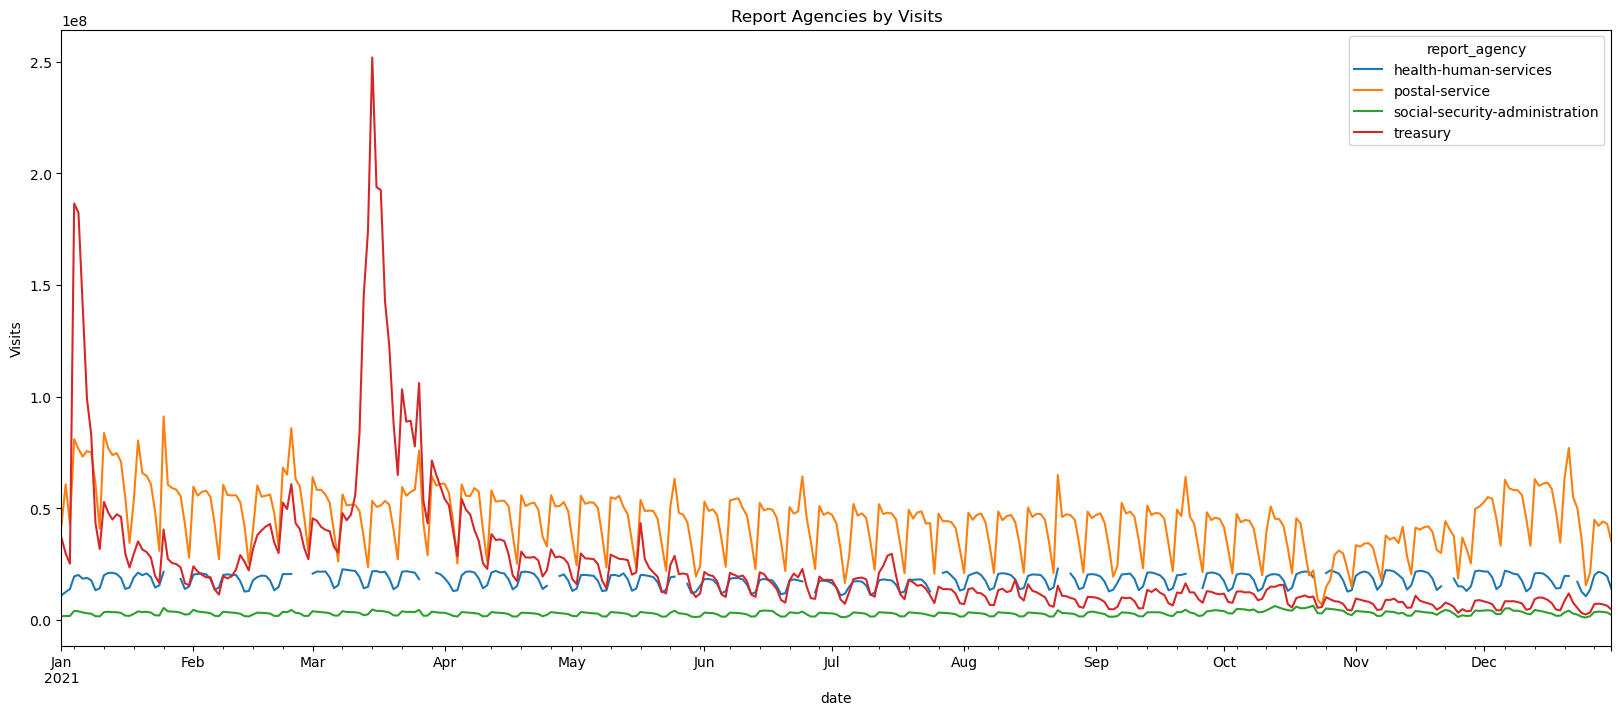

In [35]:
fig, ax = plt.subplots(figsize=(20, 8))

df_grouped = df_sites.groupby(['date', 'report_agency']).agg({'visits': 'sum'})
df_pivot = df_grouped.pivot_table(index='date', columns='report_agency', values='visits')

df_pivot = df_pivot.loc['2021-01': '2021-12']

df_pivot.plot.line(ax=ax)

plt.ylabel('Visits')
plt.title('Report Agencies by Visits')
plt.show()

- **Question 2 answer:**
    - Every agency's visits numbers have weekly seasonality patterns (weekdays have higher visits than weekends) and that is why we see a saw-toothed shape for all the plots.
    - The clearest annual seasonal trend appears in Treasury domains, where tax season (March-April) sees a large spike of visits to then flatten out for the rest of the year.
    - Postal service visits seem to have a seasonal pattern in Q4 where visits slowly ramp towards Black Friday and the holiday season.
    - Social secutiry administration and health and human services have more stable patterns throughout the year with no notable seasonality.